<a href="https://colab.research.google.com/github/cyrus-rule/Data-Science-/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc-bart
!pip install preliz

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree works by splitting the inputs based on different features of the input (ie. If x < 7, do this). We keep partitioning like this recursive baed on more conditions until we hit the max tree depth or have too few samples. The end points (leaves) then provide the prediction by labeling all of the samples in it an output value. It is a way of predicting through if/then statements

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is the length of the longest path from a root to a leaf. It's the number of decisionsi n the longest branch.If a tree is too shallow, it doesn't capture all of the patterns in the data and underfits, this looks like very dissimilar points or points part of different patterns being in the same bin. If a tree is too deep, it captures noise and overfits. This looks like connect the dots or points that are part of the same pattern being in different bins.

**Task4:**

How are BART models similar and different from a decision tree?

They are similar in that they both involve trees and have decision making rules, but BART is different bevause it uses an ensemble of many trees that each are only responsible for a small part of the prediction. Because of this, BART captures more patterns with less depth (and risk of overfitting) and also can measure uncertainty.

**Task5**:

Why would we use a BART model instead of a decision tree?

We use BART models because they can handle uncertainty better and are better able to capture patterns without overfitting. Also, individual trees are really unstable and variable, and BART eliminates most of that by taking the average of many trees

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [ ]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [ ]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [ ]:
X = penguins[['flipper_length', 'bill_depth', 'bill_length']]
Y = penguins['body_mass']

with pm.Model() as model_octps:
    s = pm.HalfNormal('s',10)
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y)
    idata = pm.sample(compute_convergence_checks=False)

Output()

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

Output()

<Axes: xlabel='y'>

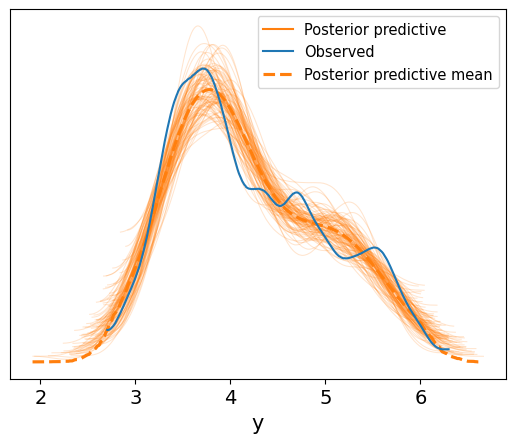

In [ ]:
pm.sample_posterior_predictive(idata,model_octps, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [ ]:

posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


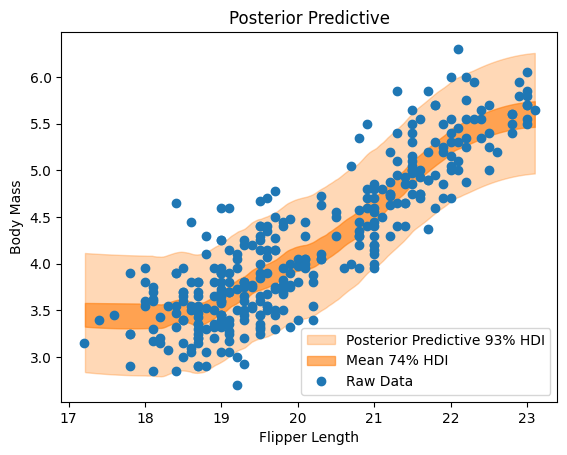

In [ ]:
idx = np.argsort(X['flipper_length'])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X['flipper_length'],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive 93% HDI"},
)

az.plot_hdi(
    x=X['flipper_length'],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean 74% HDI"},
)

ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Flipper Length",
    ylabel="Body Mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think it does! I think that there is probably a linear relationship between flipper length and body mass that this model is capturing (as evidenced by the linear trend in the model in [19,22]). The model seems to suggest that this realtionship dies out or no longer hold on the very left and very right of the data, and I don't think I believe that, especially because we were told that BART tends to flatten at the edges.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

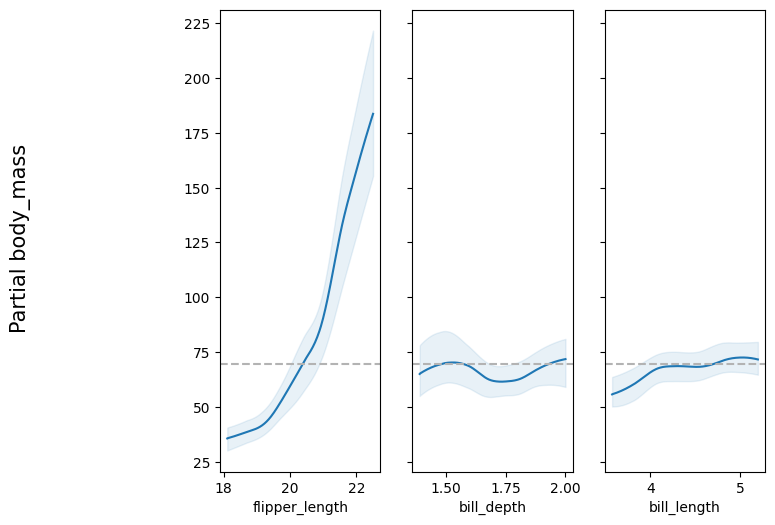

In [ ]:
pmb.plot_pdp(μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

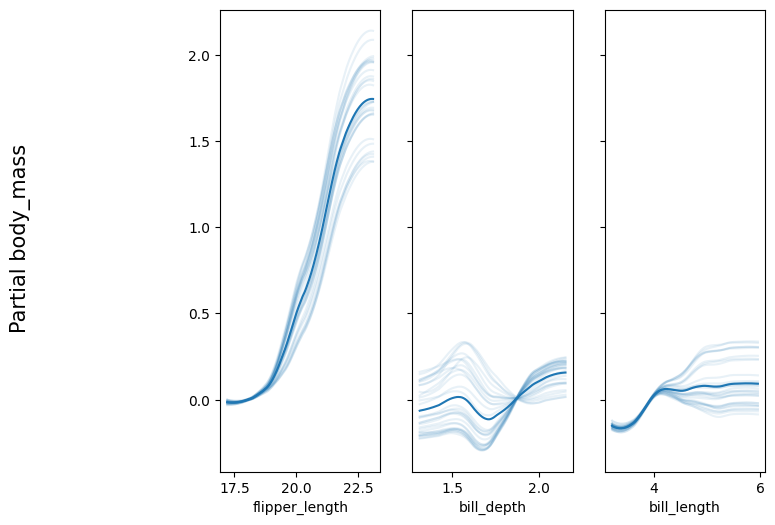

In [ ]:
pmb.plot_ice( μ, X, Y, grid=(1, 5), figsize = (12,6))

In [ ]:
vi_counties = pmb.compute_variable_importance(idata, μ, X)

<Axes: ylabel='R²'>

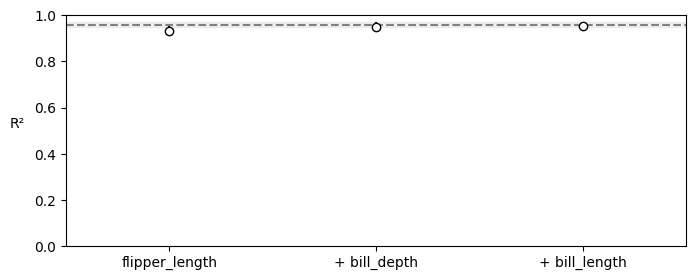

In [ ]:
pmb.plot_variable_importance(vi_counties)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

All variables seem similarly important based on the vi plot, with flipper length being slightly more important. Based on the pdps, flipper length has a linear relationship with mass, bill depth has a weird relationship we don't understand well, and bill length has a lightly positive trend. Things are definitely complicated by interactions because of the different slopes seen in the ice plots. Around 1.7, bill depth could have any in a very wide range of effects on weight, all convergng to 1 weight. This means that something else is effecting it. Similarly, bill length has a start much like flipper length (making me think its linear), but then it flattens out and becomes way less certain, making me think that something else starts impacting bill lengths' effect around 4.